In [75]:
#import modules
import argparse
import os
import random
import numpy as np
from tkinter.tix import IMAGE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from glob import glob

from PIL import Image

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)
print(torch.cuda.is_available())

# Hyperparameters
LEARNING_RATE = 0.0001
TRAINDATA = "ISIC\ISIC-2017_Training_Data"
TESTDATA = "ISIC\ISIC-2017_Test_v2_Data"
VALIDDATA = "ISIC\ISIC-2017_Validation_Data"
NUM_EPOCHS = 3
BATCH_SIZE = 1
WORKERS = 4


Device: cuda:0
True


In [76]:
class CustomDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = sorted(glob(os.path.join(self.root_dir+"\ISIC-2017_Training_Data", "*.jpg")))
        self.landmarks_frame = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.landmarks_frame)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        
        jpg_path = self.image_files[idx]

        image = Image.open(jpg_path)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        
        return sample

In [97]:

train_dataset = CustomDataset(csv_file = "ISIC-2017_Training_Part3_GroundTruth.csv",
                               root_dir=TRAINDATA,
                                transform=transforms.Compose([
                                transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])]))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True)

test_dataset = CustomDataset(csv_file = "ISIC-2017_Test_v2_Part3_GroundTruth.csv",
                               root_dir=TRAINDATA,
                                transform=transforms.Compose([
                                transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])]))

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True)

valid_dataset = CustomDataset(csv_file = "ISIC-2017_Validation_Part3_GroundTruth.csv",
                               root_dir=TRAINDATA,
                                transform=transforms.Compose([
                                transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])]))

valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True)

print(train_dataset.__getitem__(1))
print(train_dataset.__getitem__(1)["image"].shape)
print(train_dataset.__getitem__(1)["landmarks"].shape)
print(enumerate(train_dataloader))
dataiter = iter(train_dataloader)
data = next(dataiter)
print(data)
print(train_dataloader)




{'image': tensor([[[ 0.8447,  0.8447,  0.8447,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.8447,  0.8447,  0.8447,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.8618,  0.8618,  0.8618,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [ 0.9988,  0.9817,  0.9646,  ...,  0.8789,  0.8618,  0.8618],
         [ 1.0331,  0.9988,  0.9817,  ...,  0.8618,  0.8447,  0.8447],
         [ 0.9988,  0.9988,  0.9646,  ...,  0.8789,  0.8618,  0.8618]],

        [[ 0.9930,  0.9930,  0.9930,  ..., -2.0357, -2.0357, -2.0357],
         [ 0.9930,  0.9930,  0.9930,  ..., -2.0357, -2.0357, -2.0357],
         [ 0.9755,  0.9755,  0.9755,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [ 1.0630,  1.0455,  1.0455,  ...,  0.9930,  0.9755,  0.9755],
         [ 1.0805,  1.0455,  1.0280,  ...,  0.9755,  0.9580,  0.9580],
         [ 1.0455,  1.0455,  1.0105,  ...,  0.9930,  0.9755,  0.9755]],

        [[ 1.3851,  1.3851,  1.3851,  ..., -1.8044, -1.8044, -1.8044],
         [ 1.3851,  1.3851,  1.3851

In [78]:
def show_landmarks(image, landmarks):

    """Show image with landmarks"""
    image = image.numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)), interpolation='nearest')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 224, 224]) (1, 2)


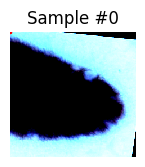

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([3, 224, 224]) (1, 2)


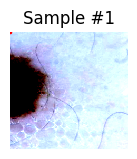

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([3, 224, 224]) (1, 2)


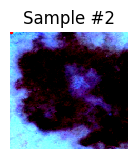

3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 torch.Size([3, 224, 224]) (1, 2)


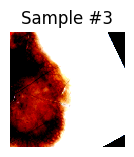

In [79]:

for i, sample in enumerate(train_dataset):
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()

        break

In [115]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1,stride=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1,stride=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
    )
    def forward(self, x):
        return self.conv(x)


In [117]:
class UNet(nn.Module):
    def __init__(self, input_channels=3,out_channels=1,features=[64,128,256,512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(2,2)
        for feature in features:
            self.downs.append(DoubleConv(input_channels, feature))    
            input_channels = feature    
        
        for feature in reversed(features):
            print()
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2,feature,kernel_size=2,stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2,feature))
        self.bottleneck = DoubleConv(features[-1],features[-1]*2)
        self.final_conv = nn.Conv2d(features[0],out_channels,kernel_size=1)
        #self.l1 = nn.Linear(input_size, hidden_size) 
    
    
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

def test():
    x = torch.randn((3, 3, 160, 160))
    model = UNet(input_channels=3, out_channels=1)
    preds = model(x)
    print(x.shape)
    print(preds.shape)
    #assert preds.shape == x.shape
test()





torch.Size([3, 1, 160, 160])
torch.Size([3, 3, 160, 160])
torch.Size([3, 1, 160, 160])


TRAIN 

In [93]:
model = UNet(3,1,[64,128,256,512]) 
model = model.to(DEVICE)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, 
                            momentum = 0.9, weight_decay = 5e-4)

total_steps = len(train_dataloader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr = LEARNING_RATE, 
                                steps_per_epoch = total_steps, epochs = NUM_EPOCHS)
print(total_steps)





2000


In [83]:
model.train()
print("> Training")

> Training


In [84]:
print(enumerate(train_dataloader))
print(train_dataloader)

In [98]:


for epoch in range(NUM_EPOCHS):
    for i, batch in enumerate(train_dataloader):
        images, labels = batch["image"], batch["landmarks"]
        print(images.shape)
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        print(images.shape)
        outputs = model(images)
        print(1,outputs)
        print(2,labels)
        loss = criterion(outputs, labels)
        #print(i)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(i)
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{total_steps}], Loss: {loss.item():.5f}')
        scheduler.step()

print("Training took " +  " secs")
print("> Testing")

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 224, 224])
1 tensor([[[[-6.3416e-01,  1.3205e-04,  3.3842e-01,  ...,  6.8583e-01,
            4.5125e-02,  5.2014e-01],
          [-4.2335e-02,  2.8007e-01, -1.7015e+00,  ...,  1.7963e-01,
            3.1758e-01,  6.8661e-01],
          [ 4.0841e-01,  1.5238e+00,  8.3609e-01,  ...,  7.1014e-01,
            1.1374e+00,  7.1231e-01],
          ...,
          [-4.0127e-01, -2.1876e-02, -1.3027e+00,  ..., -5.9824e-01,
           -7.7359e-01, -2.3807e-01],
          [-1.1986e-01,  6.9718e-01,  1.1520e+00,  ...,  3.7598e+00,
            2.2011e+00,  1.1129e+00],
          [ 7.5503e-01,  5.7923e-01,  4.1685e-01,  ...,  1.2492e+00,
            9.2655e-01,  1.7091e-01]]]], device='cuda:0',
       grad_fn=<ConvolutionBackward0>)
2 tensor([[[0., 0.]]], device='cuda:0', dtype=torch.float64)


c:\Users\John\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 2])) that is different to the input size (torch.Size([1, 1, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (224) must match the size of tensor b (2) at non-singleton dimension 3